In [1]:
import numpy as np
import pandas as pd
import os
data_dir = r"/content/drive/MyDrive/dataset/rice_plant_lacks_nutrients"
os.listdir(data_dir)

['Potassium(K)', 'Phosphorus(P)', 'Nitrogen(N)']

In [2]:
nutrient=["Nitrogen(N)","Potassium(K)","Phosphorus(P)"]
nutrient_dict={}
for i in nutrient:
    nutrient_dict[i] = os.path.join(data_dir, i)
nutrient_dict

{'Nitrogen(N)': '/content/drive/MyDrive/dataset/rice_plant_lacks_nutrients/Nitrogen(N)',
 'Potassium(K)': '/content/drive/MyDrive/dataset/rice_plant_lacks_nutrients/Potassium(K)',
 'Phosphorus(P)': '/content/drive/MyDrive/dataset/rice_plant_lacks_nutrients/Phosphorus(P)'}

In [3]:
def count_image_dir(nutrient_dict):
    count_dict = {}
    for i in nutrient_dict:
        count_dict[i] = len(os.listdir(nutrient_dict[i]))
    return count_dict
count_dict = count_image_dir(nutrient_dict)
count_dict

{'Nitrogen(N)': 440, 'Potassium(K)': 361, 'Phosphorus(P)': 334}

In [4]:
def create_df(nutrient_dict):
    file_list = []
    for i in nutrient_dict:
        file_list+= list(map(lambda x : [os.path.join(nutrient_dict[i], x), i], os.listdir(nutrient_dict[i])))
    tb_df = pd.DataFrame(file_list, columns=["filepaths", "labels"])
    return tb_df
tb_df = create_df(nutrient_dict)

In [5]:
tb_df["labels"].value_counts()


labels
Nitrogen(N)      440
Potassium(K)     361
Phosphorus(P)    334
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images = train_test_split(tb_df, test_size=0.15, random_state=42)
train_images, val_set = train_test_split(train_images, test_size=0.176, random_state=42)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                    rescale=1./255.,
                                    featurewise_center=True, # subtracts mean from pixel value
                                    featurewise_std_normalization=True, # divides by std deviation
                                    horizontal_flip=True,
                                    rotation_range=0.2
                                    )

train_data = train_datagen.flow_from_dataframe(dataframe=train_images, x_col="filepaths",
                                              y_col="labels",
                                              batch_size=8,
                                              target_size=(224, 224),
                                              class_mode="categorical"
                                              )

Found 794 validated image filenames belonging to 3 classes.


In [8]:
val_data = train_datagen.flow_from_dataframe(
                                        dataframe=val_set,x_col="filepaths",y_col="labels",
                                        batch_size = 8,
                                        target_size = (224,224),
                                        class_mode = 'categorical')
val_data.class_indices

Found 170 validated image filenames belonging to 3 classes.


{'Nitrogen(N)': 0, 'Phosphorus(P)': 1, 'Potassium(K)': 2}

In [9]:
test_data = train_datagen.flow_from_dataframe(
                                        dataframe=test_images,x_col="filepaths",y_col="labels",
                                        batch_size = 8,
                                        target_size = (224,224),
                                        class_mode = 'categorical')

Found 171 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


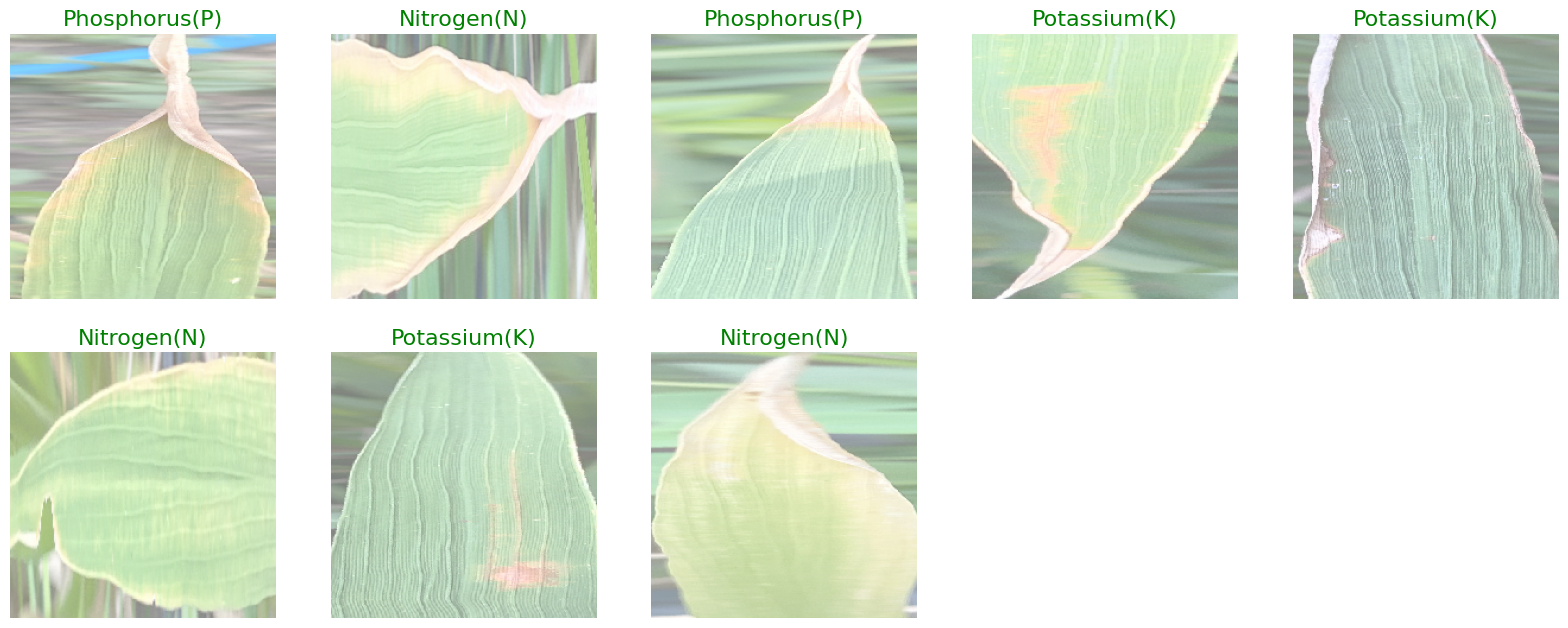

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(image_gen):
    test_dict = test_data.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 # scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_images(train_data)

In [11]:
from tensorflow.keras import Sequential, Model, layers

def ResidualBlock(x, filters, kernel_size=(3,3),strides=(1, 1), activation='relu', downsampling=False):
    if downsampling: # downsampling using strided convolutions
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=(2, 2))(x)
    else:
        shortcut = x
    # print(x.shape, shortcut.shape)
    x = layers.Conv2D(filters, kernel_size, strides, padding='same')(x)
    # print(x.shape)
    x = layers.BatchNormalization()(x)
    # print(x.shape)
    x = layers.Activation(activation)(x)
    # print(x.shape)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    # print(x.shape)
    x = layers.BatchNormalization()(x)
    # print(x.shape)
    x = layers.Add()([x, shortcut])
    # print(x.shape)
    return layers.ReLU()(x)

In [12]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, ReLU, MaxPooling2D, AveragePooling2D, Reshape

def ResNetModel(input_shape, num_classes, num_blocks=[2, 2, 2, 2], filters_ls=[64, 128, 256, 512]):
    '''
        ResNet18 model with 8 -> sum(2, 2, 2, 2) residual blocks having 2 layers each
        input_shape : input shape of image
        num_classes : number of classes, output of dense layer
        num_blocks : number of residual blocks
    '''
    inputs = Input(shape=input_shape)

    # Initial convolution (conv1)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    # print(x.shape)
    x = BatchNormalization()(x)
    # print(x.shape)
    x = ReLU()(x)
    # print(x.shape)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    # print(x.shape)
    # Conv2_x to Conv5_x
    for i in range(len(num_blocks)):
        count, max_count = 0, num_blocks[i]
        while count < max_count:
            if count == 0 and i > 0:
                x = ResidualBlock(x, filters_ls[i], (3, 3), (2, 2), 'relu', True)
            else:
                x = ResidualBlock(x, filters_ls[i], (3, 3), (1, 1), 'relu', False)
            # print(x.shape)
            count+= 1
    # Average Pooling layer, reduces feature map to (1, 1, 512)
    x = AveragePooling2D((7, 7), strides=(1, 1))(x)
    # print(x.shape)
    # Reshapes to (512, 1)
    x = Reshape((x.shape[-1],))(x)
    # print(x.shape)
    # Getting output of Dense layer with sigmoid activation
    outputs = Dense(num_classes,activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = ResNetModel(input_shape=(224, 224, 3), num_classes=3)


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
checkpoint = ModelCheckpoint(
    filepath="./TB_ResNet18_model.keras",
    monitor= 'val_loss',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
)

In [15]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=4,
            verbose=1,
            min_lr=0.0001
)

In [17]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [18]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(
                learning_rate=0.01,
                weight_decay=0.0001,
                momentum=0.9
)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
from tensorflow.test import gpu_device_name
device_name = gpu_device_name()
device_name

''

In [21]:
import tensorflow
from tensorflow.keras.callbacks import History
with tensorflow.device(device_name):
    history = History()
    model = model.fit(
        train_data,
        steps_per_epoch = train_data.samples//train_data.batch_size,
        epochs = 32,
        validation_data = val_data,
        validation_steps = val_data.samples//val_data.batch_size,
        callbacks = [tensorboard, checkpoint, early_stopping, reduce_lr, history]
        )

Epoch 1/32
99/99 [==============================] - ETA: 0s - loss: 1.5179 - accuracy: 0.5534
Epoch 1: val_loss improved from inf to 683.19305, saving model to ./TB_ResNet18_model.keras
99/99 [==============================] - 379s 4s/step - loss: 1.5179 - accuracy: 0.5534 - val_loss: 683.1931 - val_accuracy: 0.3452 - lr: 0.0100
Epoch 2/32
99/99 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.6578
Epoch 2: val_loss improved from 683.19305 to 19.85070, saving model to ./TB_ResNet18_model.keras
99/99 [==============================] - 296s 3s/step - loss: 0.8209 - accuracy: 0.6578 - val_loss: 19.8507 - val_accuracy: 0.3690 - lr: 0.0100
Epoch 3/32
99/99 [==============================] - ETA: 0s - loss: 0.9712 - accuracy: 0.6527
Epoch 3: val_loss did not improve from 19.85070
99/99 [==============================] - 290s 3s/step - loss: 0.9712 - accuracy: 0.6527 - val_loss: 30.2554 - val_accuracy: 0.3571 - lr: 0.0100
Epoch 4/32
99/99 [==============================

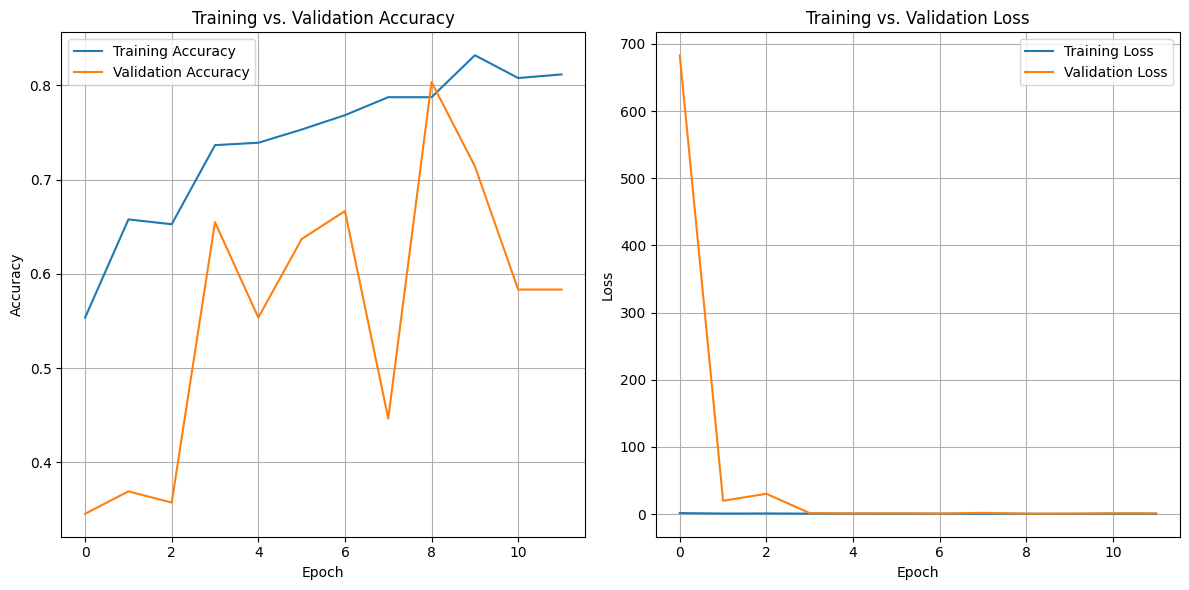

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)  # Divide the figure into two subplots
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'test_y' is not defined